# Amazon Sales Analysis - Statistical Testing
## Sarah Taghadosi - 400222019
This notebook explores the Amazon product dataset using various statistical tests to answer key questions related to product ratings, pricing, discounts, and customer behavior.


## 1. Data Loading and Cleaning

We start by loading the dataset and cleaning the price, discount, and rating columns.   

This includes removing symbols (₹, %, commas) and converting data to numeric types.


In [17]:
import pandas as pd

# Load the dataset
df = pd.read_csv("/Users/sarahtgh/Downloads/amazon.csv")

# Show the first few rows
print(df.head())

# Check column names and info
print(df.info())

# Summary statistics
print(df.describe())


   product_id                                       product_name  \
0  B07JW9H4J1  Wayona Nylon Braided USB to Lightning Fast Cha...   
1  B098NS6PVG  Ambrane Unbreakable 60W / 3A Fast Charging 1.5...   
2  B096MSW6CT  Sounce Fast Phone Charging Cable & Data Sync U...   
3  B08HDJ86NZ  boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...   
4  B08CF3B7N1  Portronics Konnect L 1.2M Fast Charging 3A 8 P...   

                                            category discounted_price  \
0  Computers&Accessories|Accessories&Peripherals|...             ₹399   
1  Computers&Accessories|Accessories&Peripherals|...             ₹199   
2  Computers&Accessories|Accessories&Peripherals|...             ₹199   
3  Computers&Accessories|Accessories&Peripherals|...             ₹329   
4  Computers&Accessories|Accessories&Peripherals|...             ₹154   

  actual_price discount_percentage rating rating_count  \
0       ₹1,099                 64%    4.2       24,269   
1         ₹349                 43%  

In [18]:
import numpy as np

# پاک‌سازی ستون‌ها
df['discounted_price'] = df['discounted_price'].str.replace('₹', '').str.replace(',', '').astype(float)
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# حذف ردیف‌هایی که مقدار ندارن
df_clean = df[['discounted_price', 'rating']].dropna()

# بررسی اولیه پس از پاک‌سازی
print(df_clean.head())


   discounted_price  rating
0             399.0     4.2
1             199.0     4.0
2             199.0     3.9
3             329.0     4.2
4             154.0     4.2


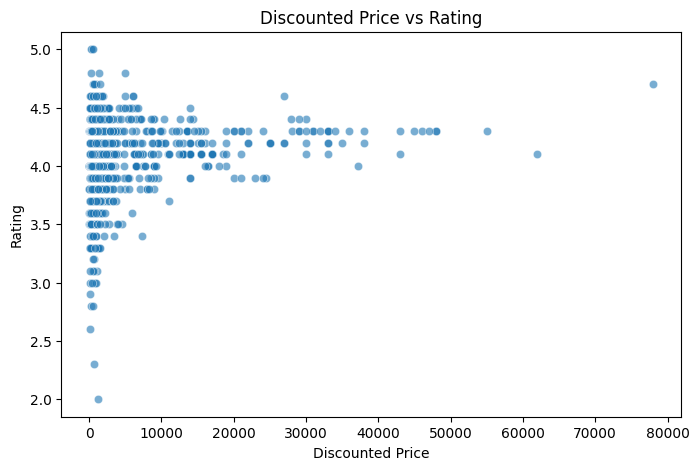

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.scatterplot(x='discounted_price', y='rating', data=df_clean, alpha=0.6)
plt.title('Discounted Price vs Rating')
plt.xlabel('Discounted Price')
plt.ylabel('Rating')
plt.show()


## 2. Does the discounted price significantly impact product ratings?

We use the Spearman Rank Correlation Test to check for a monotonic relationship between discounted price and rating.


In [19]:
from scipy.stats import spearmanr

# اجرای تست Spearman
corr, p_value = spearmanr(df_clean['discounted_price'], df_clean['rating'])

print(f"Spearman Correlation Coefficient: {corr}")
print(f"P-value: {p_value}")


Spearman Correlation Coefficient: 0.08009599207411575
P-value: 0.00216245012002074


📌 Interpretation:
- Correlation coefficient close to 0 indicates a weak relationship.
- P-value < 0.05 means the relationship is statistically significant.


<Figure size 1000x600 with 0 Axes>

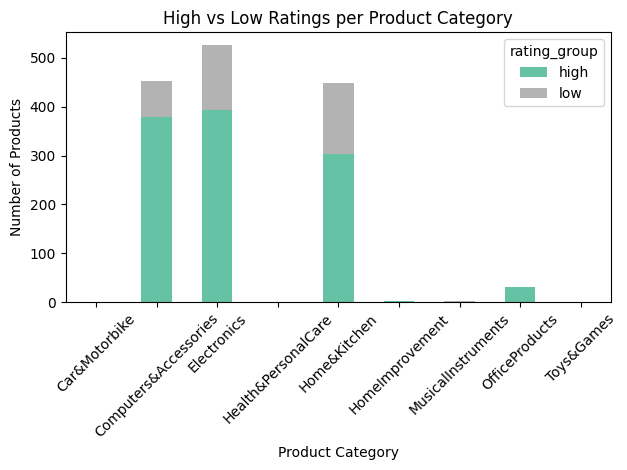

In [29]:
plt.figure(figsize=(10,6))
category_rating = pd.crosstab(df_chi['main_category'], df_chi['rating_group'])
category_rating.plot(kind='bar', stacked=True, colormap='Set2')
plt.title('High vs Low Ratings per Product Category')
plt.xlabel('Product Category')
plt.ylabel('Number of Products')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 3. Are product categories and high/low ratings independent?

We convert ratings into two groups (high ≥ 4, low < 4), extract the main category, and use the Chi-Square Test for Independence.


In [20]:
# مرحله ۱: دسته اول رو جدا می‌کنیم
df['main_category'] = df['category'].str.split('|').str[0]

# مرحله ۲: high/low rating تعریف می‌کنیم
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['rating_group'] = df['rating'].apply(lambda x: 'high' if x >= 4 else 'low')

# حذف ردیف‌های ناقص
df_chi = df[['main_category', 'rating_group']].dropna()

# مرحله ۳: جدول فراوانی
contingency_table = pd.crosstab(df_chi['main_category'], df_chi['rating_group'])
print(contingency_table)



rating_group           high  low
main_category                   
Car&Motorbike             0    1
Computers&Accessories   378   75
Electronics             393  133
Health&PersonalCare       1    0
Home&Kitchen            303  145
HomeImprovement           2    0
MusicalInstruments        1    1
OfficeProducts           31    0
Toys&Games                1    0


📌 Contingency table created. Now performing Chi-Square Test:


In [21]:
from scipy.stats import chi2_contingency

# اجرای تست کای‌دو
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}")
print(f"Degrees of Freedom: {dof}")
print(f"P-value: {p}")


Chi-Square Statistic: 46.042171064296674
Degrees of Freedom: 8
P-value: 2.333515521949709e-07


📌 Interpretation:
- A p-value < 0.05 indicates that rating and product category are NOT independent.
- There is a significant relationship between product category and user rating level.


## 4. Is there a significant difference in ratings between high-discount and low-discount products?

We divide products into two groups based on discount percentage (≥ 50% and < 50%) and use an Independent Samples T-test.


In [22]:
from scipy.stats import ttest_ind

# پاک‌سازی و تبدیل discount_percentage
df['discount_percentage'] = df['discount_percentage'].str.replace('%', '').astype(float)
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# ساخت گروه‌ها
high_discount = df[df['discount_percentage'] >= 50]['rating'].dropna()
low_discount = df[df['discount_percentage'] < 50]['rating'].dropna()

# بررسی تعداد داده‌ها در هر گروه
print(f"High Discount Count: {len(high_discount)}")
print(f"Low Discount Count: {len(low_discount)}")


High Discount Count: 751
Low Discount Count: 713


In [23]:
# اجرای تست T برای مقایسه میانگین امتیاز دو گروه
t_stat, p_value = ttest_ind(high_discount, low_discount, equal_var=False)  # Welch’s t-test

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")


T-statistic: -4.259784166512687
P-value: 2.178103002721569e-05


📌 Interpretation:
- P-value < 0.05 means there is a significant difference in average rating between high and low discount products.
- Negative T-statistic suggests high-discount products may have lower average ratings.


/var/folders/7x/st2npcgx3wdb526rvqtw1trm0000gn/T/ipykernel_4076/2722697131.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='price_group', y='rating', data=df_anova, palette='pastel')


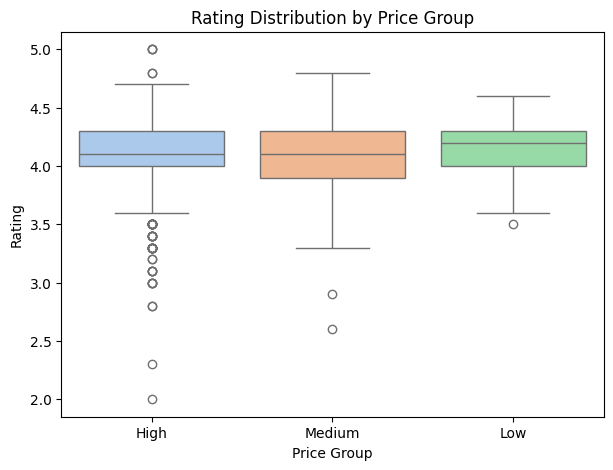

In [30]:
plt.figure(figsize=(7,5))
sns.boxplot(x='price_group', y='rating', data=df_anova, palette='pastel')
plt.title('Rating Distribution by Price Group')
plt.xlabel('Price Group')
plt.ylabel('Rating')
plt.show()


## 5. Do more expensive products receive higher ratings?

We categorize products into Low, Medium, and High price groups and compare their average ratings using ANOVA.


In [24]:
from scipy.stats import f_oneway

# تمیز کردن actual_price
df['actual_price'] = df['actual_price'].str.replace('₹', '').str.replace(',', '').astype(float)

# حذف ردیف‌هایی که امتیاز ندارن
df_anova = df[['actual_price', 'rating']].dropna()

# ساخت گروه‌های قیمتی
def price_group(price):
    if price < 300:
        return 'Low'
    elif price <= 700:
        return 'Medium'
    else:
        return 'High'

df_anova['price_group'] = df_anova['actual_price'].apply(price_group)

# بررسی تعداد هر گروه
print(df_anova['price_group'].value_counts())


price_group
High      1142
Medium     249
Low         73
Name: count, dtype: int64


In [25]:
# جدا کردن گروه‌ها
low_ratings = df_anova[df_anova['price_group'] == 'Low']['rating']
medium_ratings = df_anova[df_anova['price_group'] == 'Medium']['rating']
high_ratings = df_anova[df_anova['price_group'] == 'High']['rating']

# اجرای ANOVA
f_stat, p_value = f_oneway(low_ratings, medium_ratings, high_ratings)

print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")




F-statistic: 4.1833184235449705
P-value: 0.015430861890304204


📌 Interpretation:
- P-value < 0.05 indicates that average rating differs significantly across price groups.


## 6. Does the distribution of rating counts follow a normal distribution?

We use the Shapiro-Wilk Test to check normality of the 'rating_count' variable.


In [26]:
from scipy.stats import shapiro

# تمیز کردن ستون rating_count
df['rating_count'] = df['rating_count'].str.replace(',', '')
df['rating_count'] = pd.to_numeric(df['rating_count'], errors='coerce')

# حذف مقادیر خالی
rating_counts = df['rating_count'].dropna()

# فقط 5000 ردیف اول چون Shapiro محدودیت داره
sample = rating_counts.sample(n=min(5000, len(rating_counts)), random_state=42)

# اجرای تست Shapiro-Wilk
stat, p_value = shapiro(sample)

print(f"Shapiro-Wilk Statistic: {stat}")
print(f"P-value: {p_value}")


Shapiro-Wilk Statistic: 0.4141770307348974
P-value: 4.337208328116746e-56


📌 Interpretation:
- Very small p-value indicates rating_count is not normally distributed.
- Use non-parametric tests if needed for this variable.


### Visualization of Rating Count Distribution

We plot a histogram to visualize the distribution of rating counts.


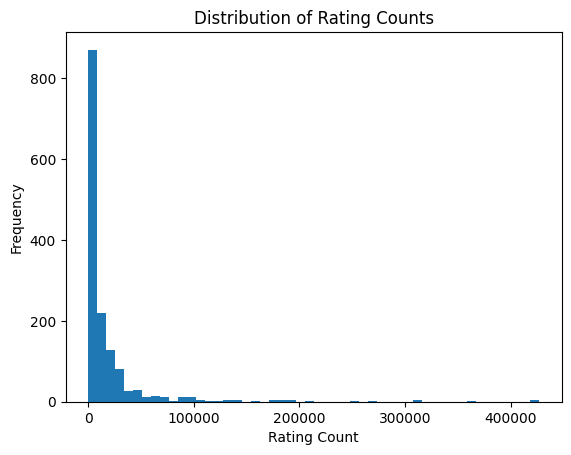

In [27]:
import matplotlib.pyplot as plt

plt.hist(rating_counts, bins=50)
plt.title('Distribution of Rating Counts')
plt.xlabel('Rating Count')
plt.ylabel('Frequency')
plt.show()


📊 The histogram of rating counts shows a highly **right-skewed distribution**.

Most products have low rating counts, while a few products have extremely high rating counts (long tail on the right). 

This confirms the result from the Shapiro-Wilk test: the distribution of rating counts is **not normal**.
